# Guide to Network Analysis (Part 4 - Find Closest Facilities)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Problem-statement" data-toc-modified-id="Problem-statement-2">Problem statement</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3">Data</a></span><ul class="toc-item"><li><span><a href="#Define-Incidents-and-Facilities-Layer" data-toc-modified-id="Define-Incidents-and-Facilities-Layer-3.1">Define Incidents and Facilities Layer</a></span></li></ul></li><li><span><a href="#Methods" data-toc-modified-id="Methods-4">Methods</a></span><ul class="toc-item"><li><span><a href="#Method-1---using-arcgis.network.analysis.find_closest_facilities" data-toc-modified-id="Method-1---using-arcgis.network.analysis.find_closest_facilities-4.1">Method 1 - using arcgis.network.analysis.find_closest_facilities</a></span><ul class="toc-item"><li><span><a href="#Tabularizing-the-response-from-find_closest_facilities" data-toc-modified-id="Tabularizing-the-response-from-find_closest_facilities-4.1.1">Tabularizing the response from find_closest_facilities</a></span></li><li><span><a href="#Visualizing-the-routes-to-the-closest-facilities" data-toc-modified-id="Visualizing-the-routes-to-the-closest-facilities-4.1.2">Visualizing the routes to the closest facilities</a></span></li></ul></li><li><span><a href="#Method-2---using-arcgis.features.use_proximity.find_nearest" data-toc-modified-id="Method-2---using-arcgis.features.use_proximity.find_nearest-4.2">Method 2 - using arcgis.features.use_proximity.find_nearest</a></span><ul class="toc-item"><li><span><a href="#Getting-incidents-and-facilities-FeatureCollection-ready" data-toc-modified-id="Getting-incidents-and-facilities-FeatureCollection-ready-4.2.1">Getting <code>incidents</code> and <code>facilities</code> FeatureCollection ready</a></span></li><li><span><a href="#With-output_name-specified" data-toc-modified-id="With-output_name-specified-4.2.2">With output_name specified</a></span></li><li><span><a href="#Without-output_name-specified" data-toc-modified-id="Without-output_name-specified-4.2.3">Without output_name specified</a></span></li><li><span><a href="#Tabularizing-the-response-from-find_nearest" data-toc-modified-id="Tabularizing-the-response-from-find_nearest-4.2.4">Tabularizing the response from find_nearest</a></span></li><li><span><a href="#Visualizing-the-response-from-find_nearest" data-toc-modified-id="Visualizing-the-response-from-find_nearest-4.2.5">Visualizing the response from find_nearest</a></span></li></ul></li></ul></li><li><span><a href="#What's-next?" data-toc-modified-id="What's-next?-5">What's next?</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6">References</a></span></li></ul></div>

## Introduction

We have learned about Network Datasets and Network Analysis services in <a href="part1_introduction_to_network_analysis.ipynb">Part 1</a>, how to find routes from one point to another, and among multiple points in <a href="part2_find_routes.ipynb">Part 2</a>, and how to generate service area in <a href="part3_generate_service_area.ipynb">Part 3</a>, let's move onto the fourth topic - how to find the closest facility. Please refer to the road map below if you want to revisit the previous topics or jump to the next topic -

 - Network Dataset and Network Analysis services (<a href="part1_introduction_to_network_analysis.ipynb">Part 1</a>) 
 - Find Routes (<a href="part2_find_routes.ipynb">Part 2</a>)
 - Generate Service Area (<a href="part3_generate_service_area.ipynb">Part 3</a>)
 - Find Closest Facility (You are here!)
 - Generate Origin Destination Cost Matrix (<a href="part5_generate_od_cost_matrix.ipynb">Part 5</a>)
 - Solve Location Allocation (<a href="part6_solve_location_allocation.ipynb">Part 6</a>)
 - Vehicle Routing Problem Service (<a href="part7_vehicle_routing_problem.ipynb">Part 7</a>)

The API of `Finding Closest Facility` is useful when you need to find out individual locations near a source feature (in this guide, we call it `incidents layer`) in a sense that the API can calculate the actual distance between each location in the incidents layer and the closest source (in the `facilities layer`). For instance, if you want to know the distance of some eagle nests from a river and what's the closest point <a href="#References">[1]</a>.

Or you can also have the API find the distance between each location (in the `incidents layer`) and several source features (in the `facilities layer`), which can be interpreted as <a href="#References">[1]</a>:
 - If you want to see which areas are near more than one source and which areas are near only one. For instance, a fast food chain might need to see which areas have many customers near several restaurants.
 - If you need to know the second or third closest source for each location. For instance, a patient might need to know the nearest and the second nearest hospitals to his/her home address.
 - If you want to compare distance to other factors. For example, customer's distance from the store would need to be weighted against the number of store visits.

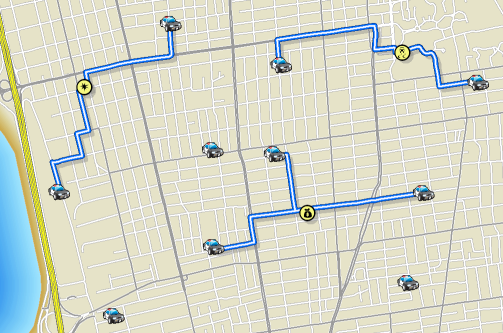

Fig 1. When a criminal incident happens, police patrol system needs to figure out which patrol vehicles are closest to the incident, in order to send the police officers over to the scene (source: <a href="#References">[2]</a>). 

This part of guide to Networking Analysis will help you measure the cost of traveling between incidents and facilities, specify how many to find and whether the direction of travel is toward or away from them, and determine which are nearest to one another, and at the end display the best routes between incidents and facilities, report their travel costs, and return driving directions <a href="#References">[2]</a>. In this part of guide, you'll be introduced to the workflow to find the closest hospital to an accident. 

Now that we have learned why finding closest facility is needed, and the basis of measuring the nearness, it is time to make your hands dirty with some real implementations!

## Problem statement

The goal of this page is to determine which facilities are closest to an incident. For this, let us assume the following scenario:

Jim is an operator working for Medical Emergency Response Office, and needs to schedule for emergency response vehicles to pick up patients from the location of incidents and transport to the nearest hospitals. Now given the three incidents reported in Redlands and Loma Linda, can Jim find the nearest hospitals for each of these incidents, and also provide them routes and directions?

Now that Jim's objectives are defined, we can go onto break down the problem:
 - Data: where to access the input datasets
 - Methods: what tools can be used to build the network model and perform closest facility analysis
 - Tables and maps: deliverables in which directions and routes are visualized.
 
Let's first access and/or explore the input datasets (in this case, the incidents and facilities feature class).

## Data

The first step to everything is always importing all required modules and establishing a GIS connection to ArcGIS Online organization or your enterprise for ArcGIS.

If you have already set up a profile to connect to your ArcGIS Online organization, execute the cell below to load the profile and create the GIS class object. If not, use a traditional username/password log-in e.g. `my_gis = GIS('https://www.arcgis.com', 'arcgis_python', 'P@ssword123', verify_cert=False, set_active=True)`

In [1]:
from arcgis.gis import GIS
import arcgis.network as network
from arcgis.features import FeatureLayer, Feature, FeatureSet, use_proximity, FeatureCollection
import pandas as pd
import time
import datetime as dt

In [2]:
my_gis = GIS('home')

### Define Incidents and Facilities Layer

Finding a closest facility can be associated with a local network dataset or a network service hosted in ArcGIS Online or ArcGIS Enterprise. Here, we will be using an existing feature layer that contains hospitals derived from various sources (refer SOURCE field) from the Homeland Infrastructure Foundation-Level Data (HIFLD) database (https://gii.dhs.gov/HIFLD), which can be accessed from `esri_livingatlas`.

If you do not have access to the hospital layer provided by `Esri_livingatlas` as referenced in the cell below, an alternative approach is for you to download the hospital listing of San Bernadino County from this <a href="https://data.chhs.ca.gov/datastore/dump/641c5557-7d65-4379-8fea-6b7dedbda40b?q=&sort=_id+asc&fields=OSHPD_ID%2CFACILITY_NAME%2CLICENSE_NUM%2CFACILITY_LEVEL_DESC%2CDBA_ADDRESS1%2CDBA_CITY%2CDBA_ZIP_CODE%2CCOUNTY_CODE%2CCOUNTY_NAME%2CER_SERVICE_LEVEL_DESC%2CTOTAL_NUMBER_BEDS%2CFACILITY_STATUS_DESC%2CFACILITY_STATUS_DATE%2CLICENSE_TYPE_DESC%2CLICENSE_CATEGORY_DESC%2CLATITUDE%2CLONGITUDE&filters=%7B%22COUNTY_CODE%22%3A+%5B%2236%22%5D%7D&format=csv">source</a> and publish the csv to the organization before proceeding forward.

You do not have permissions to access this resource or perform this operation.


Trying from an alternative source...


<Item title:"hospitals_SB_county" type:Feature Layer Collection owner:arcgis_python>
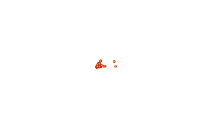

In [4]:
""" This try-except block will help you download the CSV and publish to current GIS object, if 
    "You do not have permissions to access this resource or perform this operation."
"""
try:
    hospital_item = my_gis.content.get("a2817bf9632a43f5ad1c6b0c153b0fab")
except RuntimeError as ne:
    try:
        print("Trying from an alternative source...")
        hospital_item = my_gis.content.get("50fb63f303304835a048d16bd86c3024")
    except RuntimeError as ne:
        print("Trying to publish from csv...")
        import requests
        import csv
        import os

        out_file_name = 'hospitals_SB_county.csv'
        url = "https://data.chhs.ca.gov/datastore/dump/641c5557-7d65-4379-8fea-6b7dedbda40b?q=&sort=_id+asc&fields=OSHPD_ID%2CFACILITY_NAME%2CLICENSE_NUM%2CFACILITY_LEVEL_DESC%2CDBA_ADDRESS1%2CDBA_CITY%2CDBA_ZIP_CODE%2CCOUNTY_CODE%2CCOUNTY_NAME%2CER_SERVICE_LEVEL_DESC%2CTOTAL_NUMBER_BEDS%2CFACILITY_STATUS_DESC%2CFACILITY_STATUS_DATE%2CLICENSE_TYPE_DESC%2CLICENSE_CATEGORY_DESC%2CLATITUDE%2CLONGITUDE&filters=%7B%22COUNTY_CODE%22%3A+%5B%2236%22%5D%7D&format=csv"
        download = requests.get(url)

        with open(out_file_name, 'w') as out_file:
            out_file.writelines(download.text)
            print(out_file_name)
        csv_item = my_gis.content.add({}, out_file_name)
        hospital_item = csv_item.publish()
display(hospital_item)

From the Feature Layer item, we will get the first Feature Layer which we will use for the rest of this notebook.

In [4]:
hospital_fl = hospital_item.layers[0]
hospital_fl

<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/hospitals_SB_county/FeatureServer/0">

In [5]:
""" If you are using the exisiting layer from Esri_LivngAtlas, there is a "County" column in the dataset;
    or else, the feature layer collection published from the downloaded CSV file is already targetted at SB County.
"""
try:
    facilities = hospital_fl.query(where="County='SAN BERNARDINO' AND State='CA'", as_df=False)
except RuntimeError as re:
    """ when seeing 'Invalid field: County' parameter is invalid
    """
    print("Trying from an alternative approach...")
    facilities = hospital_fl.query(where="Dba_city='REDLANDS' or Dba_city='LOMA LINDA'", as_df=False)
display(facilities)


'Invalid field: County' parameter is invalid


Trying from an alternative approach...


<FeatureSet> 33 features

Now we have the `facilities layer` ready. It has `33` hospitals as features. We can go onto define the `incidents layer`. Here, we randomly picked three locations in Redlands, CA.

In [6]:
incidents_json = {
                    "features": [{"attributes": {"CurbApproach": 0,
                                                 "ID": "C100045",
                                                 "Name": "Incident at Esri"},
                                  "geometry": {"x": -117.19569523299998, "y": 34.05608640000003}},
                                 {"attributes": {"CurbApproach": 0,
                                                 "ID": "F100086",
                                                 "Name": "Incident at APT"},
                                  "geometry": {"x": -117.20520037855628, "y": 34.04472649163186}},
                                 {"attributes": {"CurbApproach": 0,
                                                 "ID": "C100097",
                                                 "Name": "Incident at Walmart"},
                                  "geometry": {"x": -117.222253, "y": 34.065378}}],
                    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
                    "geometryType": "esriGeometryPoint",
                    "fields" : [
                        {"name" : "ID", "type" : "esriFieldTypeString", "alias" : "ID", "length" : "50"},
                        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
                        {"name" : "CurbApproach", "type" : "esriFieldTypeInteger", "alias" : "CurbApproach"}
                    ]
                }
incidents = FeatureSet.from_dict(incidents_json)

Let's have the two layers visualized in the map view.


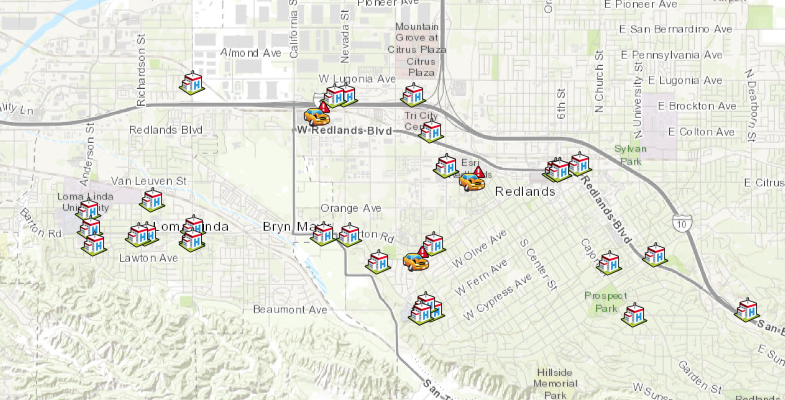

In [78]:
map1 = my_gis.map('Redlands, CA', zoomlevel=12)
map1

In [12]:
hospital_symbol = {"type":"esriPMS",
                   "url":"http://static.arcgis.com/images/Symbols/SafetyHealth/Hospital.png",
                   "contentType": "image/png", "width":20, "height":20}

map1.draw(facilities, symbol=hospital_symbol)

In [13]:
traffic_accident_symbol = {"type":"esriPMS",
                           "url":"http://static.arcgis.com/images/Symbols/Transportation/TrafficAccident.png",
                           "contentType": "image/png", "width":20, "height":20}

map1.draw(incidents, symbol=traffic_accident_symbol)

## Methods

The ArcGIS API for Python provides three ways to find closest facilities, which are namely, **ClosestFacilityLayer.solve**, **find_closest_facilities**, and **find_nearest**.

| Operation       |  network.analysis       | features.use_proximity |
|-----------------|-------------------------|------------------------|
| Route           |  find_routes            | plan_routes        |
| ServiceArea     |  generate_service_areas | create_drive_time_areas|
| ClosestFacility |  **find_closest_facilities**| **find_nearest** |

These three methods are defined in different modules of the arcgis package, and will make distinct REST calls in the back end. A key distinction between **ClosestFacilityLayer.solve** and **network.analysis.find_closest_facilities**, **features.use_proximity.find_nearest** is, the former is meant for custom or advanced closest facilities finding workflows where you need to publish your own Network Analysis layers. The latter tools work against closest facilities finding services hosted on ArcGIS Online or available on your Enterprise via proxy services and will cost you credits.

In this part of guide, we will walk through the workflows of using `network.analysis.find_closest_facilities()` and `features.use_proximity.find_nearest()` in solving the same problem - finding the closest `facilities` (defined as hospitals here) to the `incidents`, and further explore the differences in the process.

### Method 1 - using arcgis.network.analysis.find_closest_facilities

Finds one or more facilities that are closest from an incident based on travel time or travel distance and outputs the best routes, driving directions between the incidents and the chosen facilities, and a copy of the chosen facilities. You can use the tool, for example, to find the closest hospital to an accident, the closest police cars to a crime scene, or the closest store to a customer’s address. When finding closest facilities, you can specify how many to find and whether the direction of travel is toward or away from them. You can also specify the time of day to account for travel times based on live or predictive traffic conditions for that time and date. For instance, you can use the tool to search for hospitals within a 15-minute drive time of the site of an accident at a given time of day. Any hospitals that take longer than 15 minutes to reach based on the traffic conditions will not be included in the results. Parameters for the solver include:
 - `incidents`: Incidents (FeatureSet). Required parameter. Specify one or more incidents (up to 1,000). These are the locations from which the tool searches for the nearby locations.
 - `facilities`: Facilities (FeatureSet). Required parameter. Specify one or more facilities (up to 1,000). These are the locations that are searched for when finding the closest location.
 - `number_of_facilities_to_find`: Number of Facilities to Find (int). Optional parameter. Specify the number of closest facilities to find per incident
 - `cutoff`: Cutoff (float). Optional parameter. Specify the travel time or travel distance value at which to stop searching for facilities for a given incident.
 - Set `save_output_network_analysis_layer` to True if you want to output the resulting NA layer as Layer file.
 
Please refer to the <a href="https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.network.analysis.html?highlight=find_closest_facility">API ref doc</a> for more information.

In [14]:
%%time
current_time = dt.datetime.now()  
result1 = network.analysis.find_closest_facilities(incidents=incidents, facilities=facilities, 
                                                   cutoff=10, time_of_day=current_time, 
                                                   number_of_facilities_to_find=4,
                                                   save_output_network_analysis_layer=True,
                                                   gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 11.3 s


Now, check if the tool is run successfully, and what are types of the elements in the returned result set, and also get the output network analysis layer's url.

In [15]:
print("Is the tool executed successfully?", result1.solve_succeeded)

Is the tool executed successfully? True


In [21]:
result1

ToolOutput(output_routes=<FeatureSet> 12 features, output_directions=<FeatureSet> 0 features, solve_succeeded=True, output_closest_facilities=<FeatureSet> 11 features, output_network_analysis_layer={"url": "https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/closestfacility_gpserver/j38b103b375534c4395e658e6a7aa4f47/scratch/_ags_gpna33351376bcbd449db338247fb6730729.lyr"}, output_route_data=None, output_incidents=<FeatureSet> 3 features, output_facilities=<FeatureSet> 33 features, output_result_file=None)

The output `result1` is of type `arcgis.geoprocessing._support.ToolOutput` and the containing `FeatureSet`s can be parsed individually for tabularizing and mapping the results. Also, the network analysis layer is present in the `output_network_analysis_layer` component.

In [17]:
result1.output_network_analysis_layer.url

'https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/closestfacility_gpserver/j38b103b375534c4395e658e6a7aa4f47/scratch/_ags_gpna33351376bcbd449db338247fb6730729.lyr'

#### Tabularizing the response from find_closest_facilities

We can read the `output_routes` component of the returned object as DataFrame, and the `4` closest facilities (from a list of `33` possible facilities) to each of the 3 incidents. With `StartTime` and `EndTime` converted to DateTime type, and specific columns selected, the table now lists only valid information:

In [29]:
""" to create tables with valid information
"""
df4 = result1.output_routes.sdf
start_times = pd.to_datetime(df4["StartTime"], unit="ms")
end_times = pd.to_datetime(df4["EndTime"], unit="ms")
df4["StartTime"] = start_times.apply(lambda x: x.strftime("%H:%M:%S"))
df4["EndTime"] = end_times.apply(lambda x: x.strftime("%H:%M:%S"))
df4[["Name", "StartTime", "EndTime", "IncidentID", "Total_Kilometers", "Total_Minutes"]]

,Name,StartTime,EndTime,IncidentID,Total_Kilometers,Total_Minutes
0,Incident at Esri - Location 27,18:17:38,18:20:19,C100045,1.103517,2.671637
1,Incident at Esri - Location 28,18:17:38,18:20:19,C100045,1.103517,2.671637
2,Incident at Esri - Location 31,18:17:38,18:20:54,C100045,1.229031,3.254473
3,Incident at Esri - Location 4,18:17:38,18:21:29,C100045,1.710835,3.841322
4,Incident at APT - Location 5,18:17:38,18:19:09,F100086,0.772053,1.508993
5,Incident at APT - Location 12,18:17:38,18:19:14,F100086,0.692399,1.583468
6,Incident at APT - Location 16,18:17:38,18:19:36,F100086,1.093573,1.953791
7,Incident at APT - Location 30,18:17:38,18:19:50,F100086,1.288073,2.189129
8,Incident at Walmart - Location 23,18:17:38,18:21:01,C100097,1.269695,3.374696
9,Incident at Walmart - Location 26,18:17:38,18:21:12,C100097,1.413950,3.559580


The table above shows the routes from each incident location to `4` of the facilities closest to it. It also prints the time and distance to each of these facilities.

#### Visualizing the routes to the closest facilities


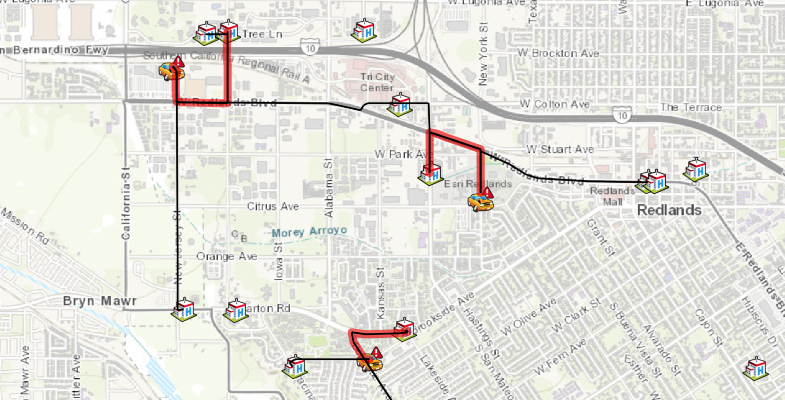

In [90]:
map2 = my_gis.map('Redlands, CA', zoomlevel=12)
map2

In [80]:
# draw the facilities and incidents on this map
map2.draw(facilities, symbol=hospital_symbol, attributes={"title":"Hospital Facility"})
map2.draw(incidents, symbol=traffic_accident_symbol, attributes={"title":"Incident Location"})

In [82]:
# draw the routes on the map
map2.add_layer(result1.output_routes)

Let us extract the closest facility to each of the incident from the routing result.

In [84]:
# sort by total minutes. Then grouop by Incident location. Finally pick the first
# route for each incident, which gives you the shortest route.
df4_shortest = df4.sort_values("Total_Minutes").groupby("IncidentID", as_index=False).first()
df4_shortest[["Name", "StartTime", "EndTime", "IncidentID", "Total_Kilometers", "Total_Minutes"]]

,Name,StartTime,EndTime,IncidentID,Total_Kilometers,Total_Minutes
0,Incident at Esri - Location 27,18:17:38,18:20:19,C100045,1.103517,2.671637
1,Incident at Walmart - Location 23,18:17:38,18:21:01,C100097,1.269695,3.374696
2,Incident at APT - Location 5,18:17:38,18:19:09,F100086,0.772053,1.508993


Now let us highlight the shortest routes. We can do that by redrawing the shortest route with a thicker and translucent symbol on the original map with all routes.

In [89]:
red_highlight_symbol = {'type': 'esriSLS', 'style': 'esriSLSSolid',
                            'color': [237, 0, 0, 100], 'width': 6}

# draw on map
map2.draw(df4_shortest.spatial.to_featureset(), 
          symbol=red_highlight_symbol)
map2.zoom=14

Next, we can save the map as a Web Map item for use later.

In [19]:
item_properties = {
    "title": "Closest Facility of hospitals in San Bernadino County from incidents (2)",
    "tags" : "NA Layer Solver, Closest Facility",
    "snippet": " Closest Facility of hospitals in San Bernadino County from incidents",
    "description": "a web map of Closest Facility of hospitals in San Bernadino County from incidents"
}

item = map2.save(item_properties)
item

<Item title:"Closest Facility of hospitals in San Bernadino County from incidents (2)" type:Web Map owner:portaladmin>

We have been using the `find_closest_facilities` tool in the `network.analysis` module up to this point. From now on, let's use a different method - `find_nearest` - defined in the `features.use_proximity` module, to achieve a workflow driven, Feature Service to Feature Service user experience.

### Method 2 - using arcgis.features.use_proximity.find_nearest

The `find_nearest` method measures the straight-line distance, driving distance, or driving time from features in the analysis layer to features in the near layer, and copies the nearest features in the near layer to a new layer. Connecting lines showing the measured path are returned as well. `find_nearest` also reports the measurement and relative rank of each nearest feature. There are options to limit the number of nearest features to find or the search range in which to find them. The results from this method can help you answer the following kinds of questions:

 - What is the nearest park from here?
 - Which hospital can I reach in the shortest drive time? And how long would the trip take on a Tuesday at 5:30 p.m. during rush hour?
 - What are the road distances between major European cities?
 - Which of these patients reside within two miles of these chemical plants?

#### Getting `incidents` and `facilities` FeatureCollection ready

In [7]:
analysis_url = my_gis.properties.helperServices.closestFacility.url
cf_layer = network.ClosestFacilityLayer(analysis_url, gis=my_gis)

Let us inspect the `ClosestFacilityLater` to get supported travel modes.

In [8]:
[i['name'] for i in cf_layer.retrieve_travel_modes()['supportedTravelModes']]

['Driving Time',
 'Driving Distance',
 'Trucking Time',
 'Trucking Distance',
 'Walking Time',
 'Walking Distance',
 'Rural Driving Time',
 'Rural Driving Distance']

Let us get the `Driving Time`, which we will call as the `car_mode`.

In [9]:
car_mode = [i for i in cf_layer.retrieve_travel_modes()['supportedTravelModes'] 
            if i['name'] == 'Driving Time'][0]

In [10]:
incidents_fc = FeatureCollection.from_featureset(incidents)
facilities_fc = FeatureCollection.from_featureset(facilities)
incidents_fc, facilities_fc

(<FeatureCollection>, <FeatureCollection>)

#### With output_name specified

When `output_name` is specified, `Find Nearest` returns a layer containing the nearest features and a line layer that links the start locations to their nearest locations. The connecting line layer contains information about the start and nearest locations and the distances between.

In [11]:
hospital_layer = {'url': hospital_fl.url, 
                  'filter': "Dba_city='REDLANDS' or Dba_city='Loma Linda'"}

In [16]:
%%time
result2 = use_proximity.find_nearest(incidents_fc, hospital_layer, measurement_type=car_mode,
                                     time_of_day=current_time, max_count=4,
                                     context={'outSR': {"wkid": 4326}},
                                     search_cutoff=10,
                                     output_name="Find nearest hospital(s) 2d",
                                     gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 36.5 s


In [17]:
result2

<Item title:"Find nearest hospital(s) 2d" type:Feature Layer Collection owner:arcgis_python>

The first sublayer of `result2` is the nearest facilities, and the second sublayer is the route.

In [18]:
result2.layers

[<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Find nearest hospital(s) 2d/FeatureServer/0">,
 <FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Find nearest hospital(s) 2d/FeatureServer/1">]

In [57]:
closest_facility_sublayer = FeatureLayer.fromitem(result2, layer_id=0)
cf_df = closest_facility_sublayer.query(where='1=1', as_df=True)
cf_df.tail()

,COUNTY_CODE,COUNTY_NAME,DBA_ADDRESS1,DBA_CITY,DBA_ZIP_CODE,ER_SERVICE_LEVEL_DESC,FACILITY_LEVEL_DESC,FACILITY_NAME,FACILITY_STATUS_DATE,FACILITY_STATUS_DESC,LATITUDE,LICENSE_CATEGORY_DESC,LICENSE_NUM,LICENSE_TYPE_DESC,LONGITUDE,OBJECTID,ORIG_FID,OSHPD_ID,SHAPE,TOTAL_NUMBER_BEDS
6,36,SAN BERNARDINO,1180 NEVADA ST,REDLANDS,92374,Not Applicable,Parent Facility,REDLANDS DENTAL SURGERY CENTER,1993-07-26,Open,34.06801,Surgical Clinic,240000513,Clinic,-117.21742,7,121,306364122,"{'x': -13048583.5065, 'y': 4037937.7673999965,...",NaN
7,36,SAN BERNARDINO,1916 ORANGE TREE LN,REDLANDS,92374,Not Applicable,Parent Facility,INLAND REGIONAL HOSPICE,2018-09-26,Open,34.06788,Hospice,550002475,Home Health Agency/Hospice,-117.21934,8,207,406361358,"{'x': -13048797.2399, 'y': 4037920.2974999994,...",NaN
8,36,SAN BERNARDINO,414 TENNESSEE ST,REDLANDS,92373,Not Applicable,Parent Facility,"BRIGHT SKY HOSPICE CARE, INC.",2013-05-29,Open,34.05792,Hospice,550002302,Home Health Agency/Hospice,-117.20004,9,245,406364508,"{'x': -13046648.7738, 'y': 4036581.9209999964,...",NaN
9,36,SAN BERNARDINO,414 TENNESSEE ST,REDLANDS,92373,Not Applicable,Parent Facility,"BRIGHT SKY HOME HEALTH CARE, INC.",2015-06-04,Open,34.05792,Home Health Agency,550003097,Home Health Agency/Hospice,-117.20004,10,256,406364523,"{'x': -13046648.7738, 'y': 4036581.9209999964,...",NaN
10,36,SAN BERNARDINO,1323 W COLTON AVE,REDLANDS,92374,Not Applicable,Parent Facility,"AMERIHEALTH HOSPICE PROVIDER, INC.",2015-03-02,Open,34.06285,Hospice,550000494,Home Health Agency/Hospice,-117.20264,11,357,406364342,"{'x': -13046938.2044, 'y': 4037244.3708999977,...",NaN


In [56]:
connected_line_sublayer = FeatureLayer.fromitem(result2, layer_id=1)
cf_df1 = connected_line_sublayer.query(where='1=1', as_df=True)
cf_df1.tail()

,EndTime,EndTimeUTC,From_CurbApproach,From_ID,From_ID_Orig,From_Name,NearRank,OBJECTID,RouteLayerItemID,RouteLayerItemURL,...,To_ID,To_LATITUDE,To_LICENSE_CATEGORY_DESC,To_LICENSE_NUM,To_LICENSE_TYPE_DESC,To_LONGITUDE,To_OSHPD_ID,To_TOTAL_NUMBER_BEDS,Total_Miles,Total_Minutes
7,2019-10-24 03:58:35,2019-10-24 10:58:35,0,2,F100086,Incident at APT,4,8,None,None,...,90,34.037440,Skilled Nursing Facility,240000211,Long Term Care Facility,-117.202570,206361351,78.0,0.679478,1.602120
8,2019-10-24 03:59:31,2019-10-24 10:59:31,0,3,C100097,Incident at Walmart,1,9,None,None,...,121,34.068010,Surgical Clinic,240000513,Clinic,-117.217420,306364122,NaN,0.795496,2.534579
9,2019-10-24 03:59:43,2019-10-24 10:59:43,0,3,C100097,Incident at Walmart,2,10,None,None,...,207,34.067880,Hospice,550002475,Home Health Agency/Hospice,-117.219340,406361358,NaN,0.885131,2.734999
10,2019-10-24 04:00:38,2019-10-24 11:00:38,0,3,C100097,Incident at Walmart,3,11,None,None,...,357,34.062850,Hospice,550000494,Home Health Agency/Hospice,-117.202640,406364342,NaN,1.310982,3.658257
11,2019-10-24 04:00:43,2019-10-24 11:00:43,0,3,C100097,Incident at Walmart,4,12,None,None,...,48,34.048272,General Acute Care Hospital,240000169,Hospital,-117.221174,106364268,28.0,1.235979,3.727673


As seen above, 12 routes are listed as routing options to closest facilities from these three incidents.

Not only can we tabularize the result, but we can also render the output Feature Service on to the map widget (as below).


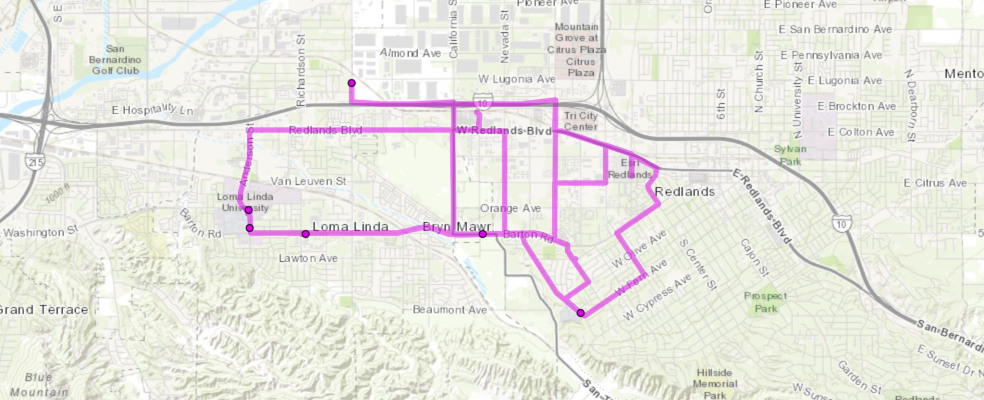

In [24]:
map4a = my_gis.map('Redlands, CA', zoomlevel=12)
map4a

In [17]:
map4a.add_layer(result2)

Now we have seen how a Feature Service (input) to Feature service (output) works, let's explore a more traditional way of solving/parsing/tabularizing/drawing user experience.

#### Without output_name specified

When you have not specified the `output_name` in the input parameters, the returned value from `find_nearest` is a dict of two FeatureCollection objects, and detailed parsing needs to be done in order to get the information on demand.

In [19]:
result2b = use_proximity.find_nearest(incidents_fc, hospital_layer, measurement_type=car_mode,
                                      time_of_day=current_time, max_count=4,
                                      context={'outSR': {"wkid": 4326}},
                                      search_cutoff=10)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


In [20]:
result2b

{'nearest_layer': <FeatureCollection>,
 'connecting_lines_layer': <FeatureCollection>}

#### Tabularizing the response from find_nearest

We can create a DataFrame out of the features contained in the returned FeatureCollection object as in `connecting_lines_layer` component.

In [22]:
df5 = result2b['connecting_lines_layer'].query().sdf
df5[['RouteName', 'Total_Miles', 'Total_Minutes']]

,RouteName,Total_Miles,Total_Minutes
0,Incident at Esri - Location 27,0.685692,2.162341
1,Incident at Esri - Location 28,0.685692,2.162341
2,Incident at Esri - Location 31,0.763683,2.665145
3,Incident at Esri - Location 4,1.063062,3.180694
4,Incident at APT - Location 5,0.268286,1.237879
5,Incident at APT - Location 12,0.430200,1.267052
6,Incident at APT - Location 16,0.679478,1.887898
7,Incident at APT - Location 30,0.800335,2.130537
8,Incident at Walmart - Location 23,0.795496,3.198604
9,Incident at Walmart - Location 26,0.885131,3.387160


#### Visualizing the response from find_nearest

First create the map view, then customize the symbology for the incidents and the facilities, and finally render the routes and stops.


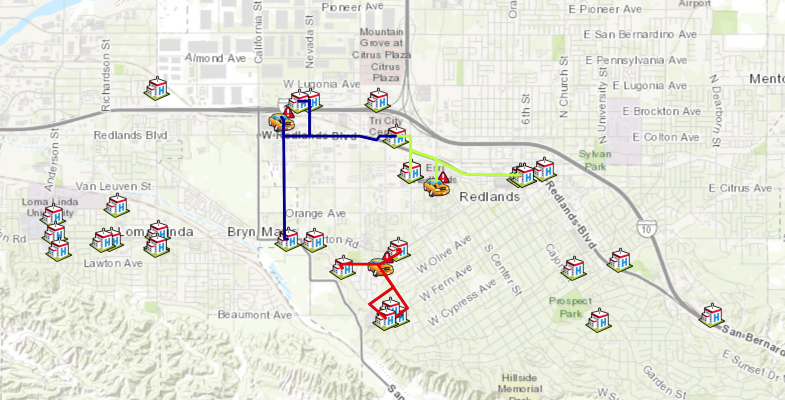

In [44]:
map4 = my_gis.map('Redlands, CA', zoomlevel=12)
map4

In [29]:
map4.draw(facilities, symbol=hospital_symbol, attributes={"title":"Hospital Facility"})

In [30]:
map4.draw(incidents, symbol=traffic_accident_symbol, attributes={"title":"Incident location"})

In [36]:
# draw the routes from each incident location in a different color
df5.spatial.plot(map4, renderer_type='u',col='From_Name')

True

In [42]:
map4.take_screenshot(set_as_preview=True, output_in_cell=False)

In [42]:
item_properties["title"] = "Closest Facility of hospitals in San Bernadino County from incidents (3) "

item = map4.save(item_properties)
item

<Item title:"Closest Facility of hospitals in San Bernadino County from incidents (3) " type:Web Map owner:portaladmin>

In the last section of this guide, we have adopted a different method - `arcgis.features.use_proximity.find_nearest` - in finding closest facilities from incidents. In doing so, we also explored the two scenarios with output_name specified (which forms a Feature Service to Feature Service user experience), and a more traditional compute/parse/draw approach when output_name is not present.

## What's next?

Part 4 has introduced `arcgis.network.analysis.find_closest_facilities` and `arcgis.features.use_proximity.find_nearest` as solvers to the closest facility problem, how to prepare for data required as input arguments by these solvers, and ways to tabularize, map, and the save the output from solvers.

Now that we have mastered techniques in finding closest facilities, let's proceed to the next topic - generating OD (origin-destination) Matrix with `network.analysis` and `features.use_proximity` modules in <a href="part5_generate_od_cost_matrix.ipynb">Part 5</a>.

## References

[1] Andy Mitchell, "The ESRI Guide to GIS Analysis, Volume 1: Geographic patterns & relationships", Esri Press, August 1999

[2] "Closest Facility Analysis", https://desktop.arcgis.com/en/arcmap/latest/extensions/network-analyst/closest-facility.htm, accessed on 09/16/2019

[3] "Find hospitals closest to an incident", https://developers.arcgis.com/python/sample-notebooks/finding-hospitals-closest-to-an-incident/, accessed on 09/16/2019